# Water

In this notebook we'll explore the Extenden Single Point Charge (SPC/E) model for water.

In [25]:
import os
import sys
import re

sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model

from read_lammps_log import read_log, get_temp_lognames
from diffusion import get_diffusion_constant

sns.set(color_codes=True)

In [2]:
%%writefile spce-simple.lt

# (NOTE: Text following # characters are comments)
#
# file "spce_simple.lt"
#
# H1 H2
# \/
# O
#
SPCE {
    # LAMMPS supports a large number of force-field styles. We must select
    # which ones we need. This information belongs in the "In Init" section.
    write_once("In Init") {
        units real # angstroms, kCal/mole, Daltons, Kelvin
        atom_style full # select column format for Atoms section
        pair_style lj/cut/coul/long 10.35 # params needed: epsilon sigma
        bond_style harmonic # parameters needed: k_bond, r0
        angle_style harmonic # parameters needed: k_theta, theta0
        kspace_style ewald 0.0001 # long-range electrostatics sum method
        pair_modify tail yes
    }
    ## Atom properties and molecular topology go in the various "Data ..." sections
    # We selected "atom_style full". That means we use this column format:
    # atomID molID atomType charge coordX coordY coordZ
    write("Data Atoms") {
        $atom:O $mol:. @atom:O -0.8476 0.0000000 0.000000 0.00000
        $atom:H1 $mol:. @atom:H 0.4238 0.8164904 0.5773590 0.00000
        $atom:H2 $mol:. @atom:H 0.4238 -0.8164904 0.5773590 0.00000
    }
    # All 3 atoms share same molID number which is unique for each water molecule
    # The "O" & "H1","H2" atoms in ALL molecules share same atom types: "O" & "H"
    write_once("Data Masses") {
        @atom:O 15.9994
        @atom:H 1.008
    }
    write("Data Bonds") {
        # bondID bondType atomID1 atomID2
        $bond:OH1 @bond:OH $atom:O $atom:H1
        $bond:OH2 @bond:OH $atom:O $atom:H2
    }
    write("Data Angles") {
        # angleID angleType atomID1 atomID2 atomID3
        $angle:HOH @angle:HOH $atom:H1 $atom:O $atom:H2
    }
    # --- Force-field parameters go in the "In Settings" section: ---
    write_once("In Settings") {
        # -- Non-bonded (Pair) interactions --
        # atomType1 atomType2 parameter-list (epsilon, sigma)
        pair_coeff @atom:O @atom:O 0.1553 3.5532
        pair_coeff @atom:H @atom:H 0.0 2.058
        # (mixing rules determine interactions between types @atom:O and @atom:H)
        # -- Bonded interactions --
        # bondType parameter list (k_bond, r0)
        bond_coeff @bond:OH 554.1349 1.0
        # angleType parameter-list (k_theta, theta0)
        angle_coeff @angle:HOH 45.7696 109.47
        # Group definitions and constraints can also go in the "In Settings" section
        group spce type @atom:O @atom:H
        #fix fSHAKE spce shake 0.0001 10 100 b @bond:OH a @angle:HOH
        # (lammps quirk: Remember to "unfix fSHAKE" during minimization.)
    }
} # SPCE

Overwriting spce-simple.lt


In [3]:
%%writefile spce-water-system.lt

# -- file "spce-water-system.lt" --
import "spce-simple.lt"

wat = new SPCE [10].move(0,0,3.45)
               [10].move(0,3.45,0)
               [10].move(3.45,0,0)

write_once("Data Boundary") {
    0.0 34.5 xlo xhi
    0.0 34.5 ylo yhi
    0.0 34.5 zlo zhi
}

Overwriting spce-water-system.lt


In [4]:
!moltemplate.sh -atomstyle "full" spce-water-system.lt

moltemplate.sh v2.10.15 2019-5-02

lttree_check.py v0.80.1 2017-10-01

    "Data Atoms" column format:
    atom-ID molecule-ID atom-type q x y z


    "Data Atoms" column format:
    atom-ID molecule-ID atom-type q x y z

lttree_check.py:    parsing the class definitions... done
lttree_check.py:    looking up classes... done
lttree_check.py:    looking up @variables... done
lttree_check.py: -- No errors detected. --
lttree.py v0.80.0 2018-10-16 
(python version 3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0])

    "Data Atoms" column format:
    atom-ID molecule-ID atom-type q x y z

parsing the class definitions... done
looking up classes... done
looking up @variables... done
constructing the tree of class definitions... done

class_def_tree = (SPCE(O, H, OH, HOH))

constructing the instance tree...
  processing command "InstantiateCommand(wat[0][0][0])"
  processing command "InstantiateCommand(wat[0][0][1])"
  processing command "InstantiateCommand(wat[0][0][2])"

  processing command "InstantiateCommand(wat[2][3][5])"
  processing command "InstantiateCommand(wat[2][3][6])"
  processing command "InstantiateCommand(wat[2][3][7])"
  processing command "InstantiateCommand(wat[2][3][8])"
  processing command "InstantiateCommand(wat[2][3][9])"
  processing command "InstantiateCommand(wat[2][4][0])"
  processing command "InstantiateCommand(wat[2][4][1])"
  processing command "InstantiateCommand(wat[2][4][2])"
  processing command "InstantiateCommand(wat[2][4][3])"
  processing command "InstantiateCommand(wat[2][4][4])"
  processing command "InstantiateCommand(wat[2][4][5])"
  processing command "InstantiateCommand(wat[2][4][6])"
  processing command "InstantiateCommand(wat[2][4][7])"
  processing command "InstantiateCommand(wat[2][4][8])"
  processing command "InstantiateCommand(wat[2][4][9])"
  processing command "InstantiateCommand(wat[2][5][0])"
  processing command "InstantiateCommand(wat[2][5][1])"
  processing command "InstantiateCommand(wat[2][

  processing command "InstantiateCommand(wat[4][2][6])"
  processing command "InstantiateCommand(wat[4][2][7])"
  processing command "InstantiateCommand(wat[4][2][8])"
  processing command "InstantiateCommand(wat[4][2][9])"
  processing command "InstantiateCommand(wat[4][3][0])"
  processing command "InstantiateCommand(wat[4][3][1])"
  processing command "InstantiateCommand(wat[4][3][2])"
  processing command "InstantiateCommand(wat[4][3][3])"
  processing command "InstantiateCommand(wat[4][3][4])"
  processing command "InstantiateCommand(wat[4][3][5])"
  processing command "InstantiateCommand(wat[4][3][6])"
  processing command "InstantiateCommand(wat[4][3][7])"
  processing command "InstantiateCommand(wat[4][3][8])"
  processing command "InstantiateCommand(wat[4][3][9])"
  processing command "InstantiateCommand(wat[4][4][0])"
  processing command "InstantiateCommand(wat[4][4][1])"
  processing command "InstantiateCommand(wat[4][4][2])"
  processing command "InstantiateCommand(wat[4][

  processing command "InstantiateCommand(wat[5][8][9])"
  processing command "InstantiateCommand(wat[5][9][0])"
  processing command "InstantiateCommand(wat[5][9][1])"
  processing command "InstantiateCommand(wat[5][9][2])"
  processing command "InstantiateCommand(wat[5][9][3])"
  processing command "InstantiateCommand(wat[5][9][4])"
  processing command "InstantiateCommand(wat[5][9][5])"
  processing command "InstantiateCommand(wat[5][9][6])"
  processing command "InstantiateCommand(wat[5][9][7])"
  processing command "InstantiateCommand(wat[5][9][8])"
  processing command "InstantiateCommand(wat[5][9][9])"
  processing command "InstantiateCommand(wat[6][0][0])"
  processing command "InstantiateCommand(wat[6][0][1])"
  processing command "InstantiateCommand(wat[6][0][2])"
  processing command "InstantiateCommand(wat[6][0][3])"
  processing command "InstantiateCommand(wat[6][0][4])"
  processing command "InstantiateCommand(wat[6][0][5])"
  processing command "InstantiateCommand(wat[6][

  processing command "InstantiateCommand(wat[8][9][2])"
  processing command "InstantiateCommand(wat[8][9][3])"
  processing command "InstantiateCommand(wat[8][9][4])"
  processing command "InstantiateCommand(wat[8][9][5])"
  processing command "InstantiateCommand(wat[8][9][6])"
  processing command "InstantiateCommand(wat[8][9][7])"
  processing command "InstantiateCommand(wat[8][9][8])"
  processing command "InstantiateCommand(wat[8][9][9])"
  processing command "InstantiateCommand(wat[9][0][0])"
  processing command "InstantiateCommand(wat[9][0][1])"
  processing command "InstantiateCommand(wat[9][0][2])"
  processing command "InstantiateCommand(wat[9][0][3])"
  processing command "InstantiateCommand(wat[9][0][4])"
  processing command "InstantiateCommand(wat[9][0][5])"
  processing command "InstantiateCommand(wat[9][0][6])"
  processing command "InstantiateCommand(wat[9][0][7])"
  processing command "InstantiateCommand(wat[9][0][8])"
  processing command "InstantiateCommand(wat[9][

In [13]:
%%writefile scripts/water.in

include "spce-water-system.in"

variable bins equal 200

timestep 1.0
fix   fxnpt all npt temp ${T} ${T} 100.0 iso 1.0 1.0 1000.0 drag 1.0
#dump  1 all custom 10 dat/water_${T}.lammpstrj id mol type x y z ix iy iz

thermo 10
run 2000

reset_timestep 0
# Add com to remove drift in the system. Water is running all over the place.
compute msd all msd com yes
compute myrdf all rdf ${bins}

variable time equal dt*step

fix 2 all ave/time 100 1 100 c_myrdf[*] file dat/water_rdf_${T}.log mode vector

thermo_style custom step v_time temp ke pe etotal press c_msd[4]
log dat/water_g_${T}.log


thermo 10
run   5000

Overwriting scripts/water.in


In [20]:
%%writefile scripts/run_water_simulations.sh

export OMP_NUM_THREADS=4

for T in $(seq 100 10 400); do
    mpirun -np 4 lmp -var T $T -in scripts/water.in
done

Overwriting scripts/run_water_simulations.sh


In [19]:
!bash scripts/run_water_simulations.sh

LAMMPS (4 Jan 2019)
  using 4 OpenMP thread(s) per MPI task
Reading data file ...
  orthogonal box = (0 0 0) to (34.5 34.5 34.5)
  1 by 2 by 2 MPI processor grid
  reading atoms ...
  3000 atoms
  scanning bonds ...
  2 = max bonds/atom
  scanning angles ...
  1 = max angles/atom
  reading bonds ...
  2000 bonds
  reading angles ...
  1000 angles
Finding 1-2 1-3 1-4 neighbors ...
  special bond factors lj:   0          0          0         
  special bond factors coul: 0          0          0         
  2 = max # of 1-2 neighbors
  1 = max # of 1-3 neighbors
  1 = max # of 1-4 neighbors
  2 = max # of special neighbors
3000 atoms in group spce
Ewald initialization ...
  using 12-bit tables for long-range coulomb (src/kspace.cpp:321)
  G vector (1/distance) = 0.244483
  estimated absolute RMS force accuracy = 0.0398566
  estimated relative force accuracy = 0.000120027
  KSpace vectors: actual max1d max3d = 709 7 1687
                  kxmax kymax kzmax  = 7 7 7
Neighbor list info ...
  

     750     157.6948   -6787.4968    589.89275   -4787.8995    1479.2269    44643.224 
     760    162.27826   -6459.1911    194.75833   -4813.7544    993.14721    44595.897 
     770     159.1862   -6864.5892    601.04762   -4840.5046   -178.11333    44550.421 
     780    160.35627   -6538.0876    237.61538   -4866.9755    -1113.589    44506.427 
     790    158.26797   -6853.1312    545.96547   -4892.3372    -1622.443    44464.667 
     800    163.38908   -6659.6302    281.23843   -4917.7833   -1245.5874    44424.048 
     810    161.63211   -6814.0956    426.33987   -4942.8537    -296.2154    44383.641 
     820    160.98394   -6722.0312    315.76608   -4967.1574    724.66067    44342.958 
     830    159.99491   -6741.6909    321.29059   -4990.1339    1130.1126    44301.982 
     840    157.05433   -6829.0909    411.09447   -5014.0172    751.87764    44260.032 
     850    157.19957    -6726.552    283.75835    -5037.516   -145.44769    44216.485 
     860    152.70782   -6967.68

    1690    114.46784   -7507.3327    334.28217   -6149.7711   -635.68745    41823.146 
    1700    114.94803   -7622.1587    437.74654     -6156.84   -1011.2898    41785.629 
    1710    116.44434    -7555.748     350.5707    -6164.229   -969.20281     41744.95 
    1720    114.03942   -7599.0483    408.23976   -6171.3589   -510.06304     41701.54 
    1730    115.22942   -7560.0392    351.37801   -6178.5736    34.303721    41656.524 
    1740     112.2621   -7569.5519    380.15855   -6185.8321    553.82843    41610.705 
    1750    110.17346    -7527.752    350.82524   -6192.0366    716.16244     41565.73 
    1760    111.04963   -7556.1349      365.149   -6198.2634    442.56703    41522.988 
    1770    112.70661   -7599.7754      388.608   -6203.6324   -71.484846    41482.804 
    1780    113.01307   -7593.0999    372.99917   -6209.8261   -498.57304    41444.878 
    1790    111.97382   -7639.6844    422.50581   -6216.1944   -616.02535    41408.914 
    1800    111.91052    -7578.6

     310          310    102.09214    912.64752   -7353.0815   -6440.4339    91.323369   0.71762134 
     320          320    103.88198    928.64767   -7371.9752   -6443.3275    440.16487   0.73635253 
     330          330    103.33703    923.77617   -7369.3801   -6445.6039    672.07949   0.75800009 
     340          340    103.22306     922.7573   -7370.2025   -6447.4452    615.36683      0.78089 
     350          350    102.24378    914.00306   -7363.9509   -6449.9479    317.88869   0.80444397 
     360          360    102.03967    912.17848   -7364.4421   -6452.2636   -39.437571   0.82280937 
     370          370     103.5418    925.60668   -7380.1939   -6454.5872   -387.19278   0.83851617 
     380          380    104.20587    931.54306   -7387.7563   -6456.2132   -400.99007   0.85560157 
     390          390    105.18256     940.2742   -7399.2945   -6459.0203   -226.82502   0.87672377 
     400          400     104.1385    930.94085   -7393.6624   -6462.7215    155.51491   0.

    1130         1130    101.92838     911.1836   -7472.4884   -6561.3048   -682.31171    1.8799194 
    1140         1140    101.85844    910.55839    -7473.433   -6562.8746   -626.96279    1.8871122 
    1150         1150     100.2921    896.55617   -7460.7691   -6564.2129   -343.99278    1.8965428 
    1160         1160    101.26822    905.28208   -7470.7326   -6565.4505   -61.018563    1.9045184 
    1170         1170    101.32504    905.79006   -7472.0489   -6566.2588    190.29695    1.9134525 
    1180         1180    99.112118    886.00776   -7453.6625   -6567.6547    265.75399    1.9202789 
    1190         1190    98.690454    882.23832   -7450.4192   -6568.1809    146.51756     1.928719 
    1200         1200    99.237521    887.12879   -7456.0059   -6568.8771   -120.59297    1.9366917 
    1210         1210    101.54393    907.74684   -7477.0244   -6569.2775   -297.37444    1.9445779 
    1220         1220    100.76111    900.74887   -7470.9431   -6570.1942   -283.17384    1

    1950         1950    99.883167    892.90051   -7508.9815    -6616.081    71.562606    2.5820185 
    1960         1960    96.700826    864.45213   -7481.0282    -6616.576   -37.241859    2.5877753 
    1970         1970    97.892162    875.10203    -7492.117    -6617.015   -219.90421    2.5898659 
    1980         1980    98.193444    877.79531   -7494.4478   -6616.6525   -269.66695    2.5968134 
    1990         1990    97.999958    876.06566    -7492.477   -6616.4113    -191.4665    2.6036396 
    2000         2000    101.34354    905.95546   -7521.5888   -6615.6333   -120.35292    2.6105064 
    2010         2010    101.77039    909.77125    -7524.701   -6614.9298     -20.2913    2.6164485 
    2020         2020    99.950086    893.49873   -7508.2989   -6614.8002      30.1235    2.6246215 
    2030         2030    100.11055    894.93319   -7509.4972    -6614.564   -103.49653    2.6244235 
    2040         2040    101.35207    906.03174   -7520.1524   -6614.1206   -288.89475    2

    2770         2770    99.645258    890.77373   -7516.5514   -6625.7776    183.96997    3.1923658 
    2780         2780    100.41853    897.68641   -7523.7537   -6626.0673    204.48511    3.1996409 
    2790         2790    99.495408    889.43416   -7515.9136   -6626.4794    147.76152    3.2061218 
    2800         2800    99.018151    885.16775   -7512.3526   -6627.1849    42.857341    3.2115949 
    2810         2810     101.4993    907.34787   -7534.9723   -6627.6245   -84.891492    3.2161364 
    2820         2820    100.24261    896.11371   -7524.6827    -6628.569   -30.206263     3.221306 
    2830         2830    100.54414    898.80923   -7527.8493   -6629.0401     63.77996    3.2306415 
    2840         2840    99.266947    887.39184    -7516.516   -6629.1242    213.98366    3.2406925 
    2850         2850    98.853745    883.69805   -7513.3874   -6629.6893    312.77785    3.2521998 
    2860         2860    99.477463    889.27374   -7518.5406   -6629.2669    294.15693    3

    3590         3590    99.860539    892.69823   -7529.3202   -6636.6219     -165.081    3.7505437 
    3600         3600    100.11244    894.95006   -7531.9281    -6636.978   -82.364877    3.7565701 
    3610         3610    100.16537    895.42328    -7532.835   -6637.4117    25.132679    3.7566149 
    3620         3620    101.42062    906.64454   -7544.4507   -6637.8062     45.75332    3.7584117 
    3630         3630    100.42777    897.76892   -7536.1942   -6638.4253    58.393886    3.7592572 
    3640         3640    99.747855    891.69089   -7530.6642   -6638.9733   -1.9467586    3.7632784 
    3650         3650      101.227    904.91361   -7543.7385   -6638.8248   -121.68333    3.7671329 
    3660         3660    100.86634    901.68953   -7540.4951   -6638.8056   -154.79887    3.7766073 
    3670         3670    99.744575    891.66157   -7530.9381   -6639.2766   -104.15314    3.7847515 
    3680         3680    99.835493    892.47433   -7531.4506   -6638.9763   -14.561378    3

In [23]:
temperature_list, file_list = get_temp_lognames("water_g")

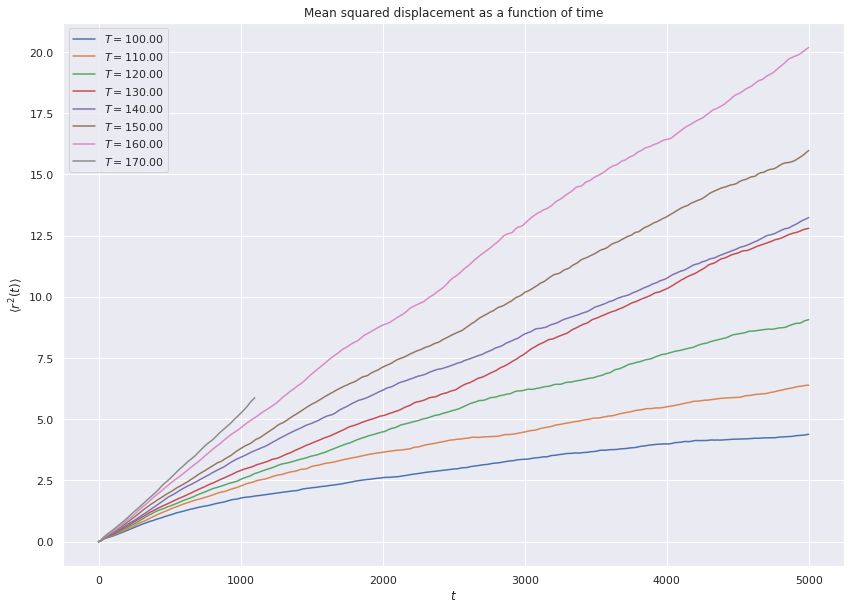

In [24]:
fig = plt.figure(figsize=(14, 10))

log_df_list = []

for T, filename in zip(temperature_list, file_list):
    log_df = read_log(filename)
    log_df_list.append(log_df)
    plt.plot(
        log_df["v_time"],
        log_df["c_msd[4]"],
        label=fr"$T = {T:.2f}$"
    )

plt.xlabel(r"$t$")
plt.ylabel(r"$\langle r^2(t)\rangle$")
plt.legend(loc="best")
plt.title(r"Mean squared displacement as a function of time")
plt.show()

In [26]:
D_list = []
alpha_list = []

for T, log_df in zip(temperature_list, log_df_list):
    D, D_int, alpha, alpha_int = get_diffusion_constant(log_df)

ValueError: x and y must have same first dimension, but have shapes (8,) and (0,)

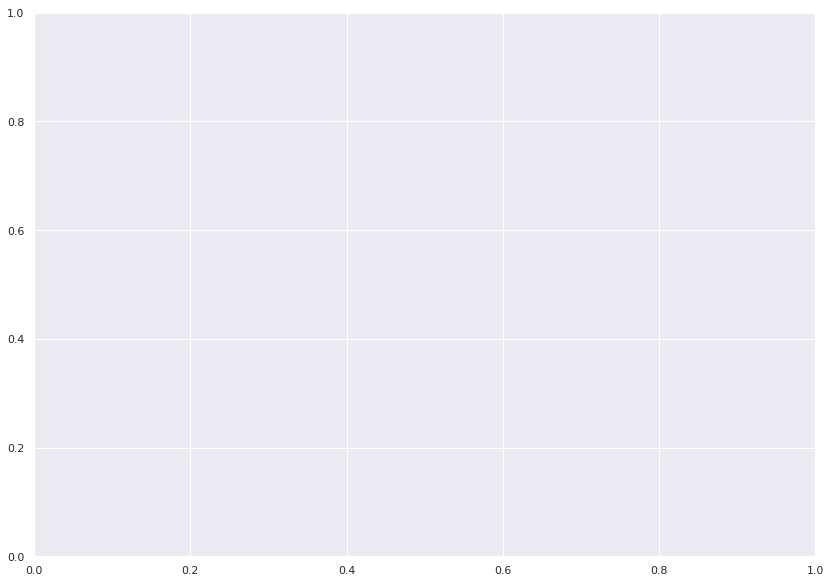

In [27]:
fig = plt.figure(figsize=(14, 10))

plt.plot(temperature_list, D_list)
plt.title(r"Plot of the diffusion constant as a function of temperature")
plt.xlabel(r"$T$")
plt.ylabel(r"$D(t)$")
plt.show()